**Install *torchsummary* to view the visualization of the model**

In [1]:
!pip install torchsummary

**Import the necessary Libraries**

In [2]:
import gc, os, cv2, PIL, torch
import torchvision as tv
import torch.nn as nn
import torchsummary as ts
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

**Read the *labels.csv* file that contains metadata on traffic sign labels**

In [3]:
labels_df = pd.read_csv('../input/traffic-signs-classification/labels.csv')
labels_df

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


**Import the dataset of Images along with the labels that are needed to train and test the model**

In [4]:
%%time 
# %%time used to calculate total time taken to execute the cell

x , y = [] , []
# X to store images and y to store respective labels  

data_dir = '../input/traffic-signs-classification/myData'
for folder in range(43):
    folder_path = os.path.join(data_dir,str(folder))
    # os.path.join just join both string 
    
    for i,img in enumerate(os.listdir(folder_path)):
        img_path = os.path.join(folder_path,img)
        img_tensor = tv.transforms.ToTensor()(PIL.Image.open(img_path))
        # PIL load the image as PIL object and ToTensor() convert this to a Tensor
        
        x.append(img_tensor.tolist())
        # convert the tensor to list of list and append
        y.append(folder)
        
    print('folder of label',folder,'images loaded. Number of samples :',i+1)
x = np.array(x)
y = np.array(y)

folder of label 0 images loaded. Number of samples : 451
folder of label 1 images loaded. Number of samples : 4920
folder of label 2 images loaded. Number of samples : 2610
folder of label 3 images loaded. Number of samples : 2670
folder of label 4 images loaded. Number of samples : 3750
folder of label 5 images loaded. Number of samples : 3510
folder of label 6 images loaded. Number of samples : 780
folder of label 7 images loaded. Number of samples : 2730
folder of label 8 images loaded. Number of samples : 2670
folder of label 9 images loaded. Number of samples : 2790
folder of label 10 images loaded. Number of samples : 3810
folder of label 11 images loaded. Number of samples : 2490
folder of label 12 images loaded. Number of samples : 3990
folder of label 13 images loaded. Number of samples : 4080
folder of label 14 images loaded. Number of samples : 1470
folder of label 15 images loaded. Number of samples : 1170
folder of label 16 images loaded. Number of samples : 780
folder of 

**Handling Imbalanced Dataset**

**Check - dataset is balanced or not**

In [5]:
# np.unique returns all the labels as one array and 
#number of samples available respect to that label as another array.

np.unique(y,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 array([ 451, 4920, 2610, 2670, 3750, 3510,  780, 2730, 2670, 2790, 3810,
        2490, 3990, 4080, 1470, 1170,  780, 2100, 2280,  390,  660,  600,
         720,  960,  510, 2850, 1140,  450, 1020,  510,  840, 1470,  450,
        1288,  780, 2280,  720,  390, 3930,  570,  660,  450,  450]))

**So as per the above result if the dataset is very imbalanced and needed to be balanced, apply Over-Sampling to balance the dataset**

In [6]:
x = x.reshape(x.shape[0],3*32*32)
# flatten x as RandomOverSampler only accepts 2-D matrix

x,y = RandomOverSampler().fit_resample(x,y)
# RandomOverSampler method duplicates samples in the minority class to balance dataset

x = x.reshape(x.shape[0],3,32,32)
# reshaped again as it was

x.shape, y.shape

((211560, 3, 32, 32), (211560,))

**Check again if the dataset is balanced or not**

In [7]:
np.unique(y,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 array([4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920,
        4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920,
        4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920,
        4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920, 4920]))

**Split the dataset for training and testing**

In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,stratify=y)
# Stratified split on the dataset 

del x,y
gc.collect()
# delete x,y and free the memory 

xtrain.shape, xtest.shape, ytrain.shape, ytest.shape
# splited data shapes

((169248, 3, 32, 32), (42312, 3, 32, 32), (169248,), (42312,))

**Display 100 Images from train samples as a Grid**

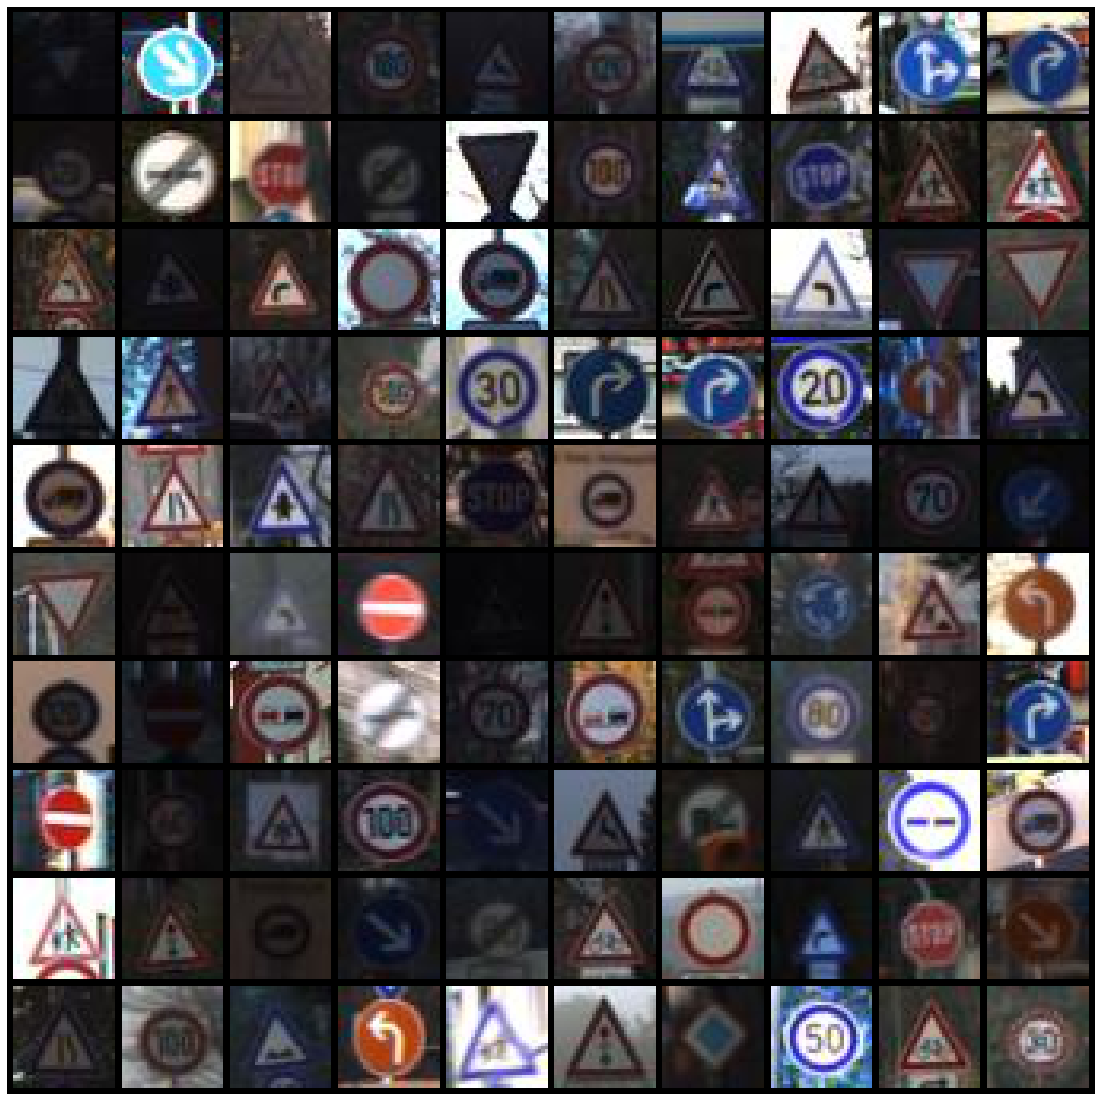



Labels of the above images :



array([13, 38, 21,  7, 31,  8, 29, 29, 36, 33,  8, 41, 14,  6, 13,  7, 23,
       14, 28, 28, 19, 30, 20, 15, 16, 24, 20, 19, 13, 13, 30, 27, 25,  7,
        1, 33, 33,  0, 35, 19, 16, 24, 11, 24, 14, 16, 27, 18,  4, 39, 13,
       23, 19, 17, 19, 26,  9, 40, 25, 34,  8, 17,  9, 41,  4,  9, 36,  5,
        8, 33, 17,  3, 30,  7, 38, 31, 42, 27,  9, 16, 28, 26, 16, 38,  6,
       29, 15, 20, 14, 38, 24,  7, 22, 34, 28, 26, 12,  2, 29,  1])

In [9]:
plt.figure(figsize=(20,20)) 

plt.imshow(tv.utils.make_grid(torch.tensor(xtrain[:100]),nrow=10).permute(1,2,0))
# make_grid creates a grid of 100 images and show it

plt.axis('off')
# To remove xticks and yticks

plt.show()
print('\n\nLabels of the above images :\n')
ytrain[:100]

**Convert train and test data from numpy array to tensor for further computations**

In [10]:
xtrain = torch.from_numpy(xtrain) 
ytrain = torch.from_numpy(ytrain)
xtest = torch.from_numpy(xtest)
ytest = torch.from_numpy(ytest)

**Initializing the Convolutional Neural Network (CNN) Model**

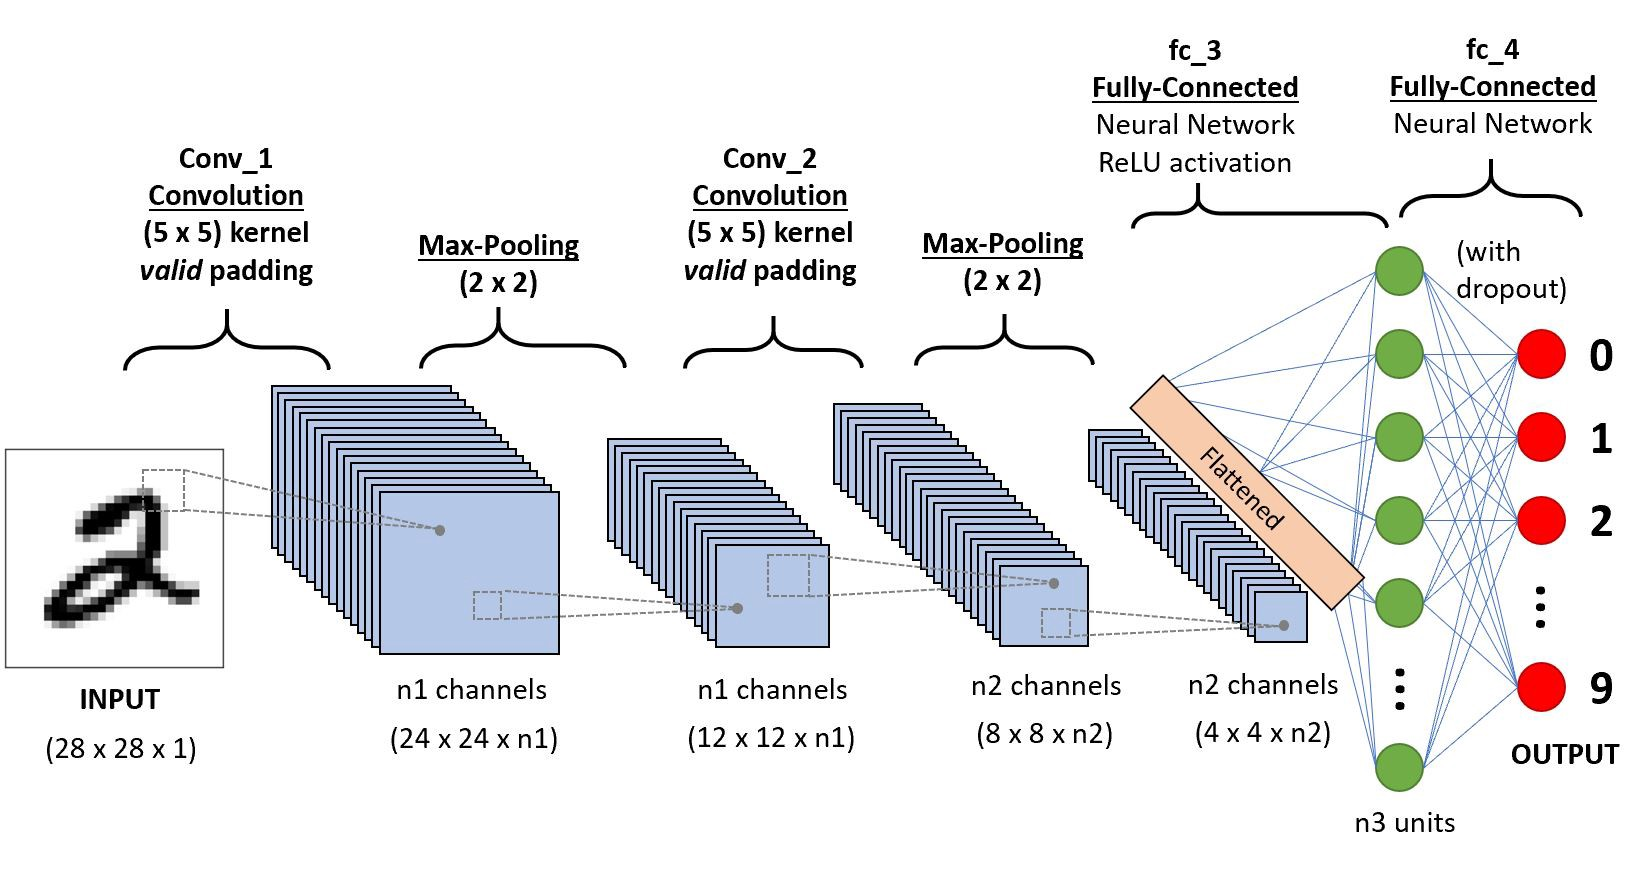

In [11]:
model = nn.Sequential(
                        # 1st convolutional network Layers
                        nn.Conv2d(3,16,(2,2),(1,1),'same'),   # Convolution
                        nn.BatchNorm2d(16),                   # Normalization 
                        nn.ReLU(True),                       # Activation
                        nn.MaxPool2d((2,2)),                 # Pooling
    
                        # 2nd convolutional network Layers
                        nn.Conv2d(16,32,(2,2),(1,1),'same'),  # Convolution
                        nn.BatchNorm2d(32),                  # Normalization 
                        nn.ReLU(True),                       # Activation
                        nn.MaxPool2d((2,2)),                 # Pooling
    
                        # 3rd convolutional network Layers
                        nn.Conv2d(32,64,(2,2),(1,1),'same'), # Convolution
                        nn.BatchNorm2d(64),                  # Normalization 
                        nn.ReLU(True),                       # Activation
                        nn.MaxPool2d((2,2)),                 # Pooling

                        # Flatten Data
                        nn.Flatten(),                        # Flatten
    
                        # feed forward Layers
                        nn.Linear(1024,256),                  # Linear 
                        nn.ReLU(True),                       # Activation
                        nn.Linear(256,43)                    # Linear 
                    )

# Send model to Cuda Memory
model = model.to(torch.device('cuda'),non_blocking=True)

# For Model Summary
ts.summary(model,(3,32,32))

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py:444: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/Convolution.cpp:743.)
  self.padding, self.dilation, self.groups)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             208
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           2,080
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]           8,256
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                  [

**Define the *evaluate* Function for model loss and accuracy evaluation**

In [12]:
def evaluate(model, data, target):
    
    # sending data and target to cuda memory
    data = data.to(torch.device('cuda'),non_blocking=True)
    target = target.to(torch.device('cuda'),non_blocking=True)
    length = len(target)
    
    yhat = model(data)
    # predict on data
    
    ypred = yhat.argmax(axis=1)
    # claculate the prediction labels from yhat
    
    loss = float(nn.functional.cross_entropy(yhat, target))
    # calculate the loss
    
    acc = float((ypred == target).sum() / length)
    # Calculate accuracy
    
    print('Loss :',round(loss,4),'- Accuracy :',round(acc,4))
    # Print loss and Accuracy
    
    del data,target,yhat,ypred
    # delete the used variables
    
    torch.cuda.empty_cache()
    # Free the Cuda memory

**Evaluate the Model on test data before training**

In [13]:
print('\nInitial Loss and Accuracy on Test Dataset :')
evaluate(model,xtest.float(),ytest)


Initial Loss and Accuracy on Test Dataset :
Loss : 3.7934 - Accuracy : 0.027


**Define *train_model* Function to train the model**

In [14]:
def train_model(model=model,optimizer=torch.optim.Adam,epochs=5,batch_size=200,steps_per_epochs=200,l2_reg=0,max_lr=0.01,grad_clip=0.5):
    
    hist = [[],[],[],[]]
    # hist will stores train and test data losses and accuracy of every epochs
    
    train_ds = [(x,y) for x,y in zip(xtrain,ytrain)]
    
    # Prepare training dataset for Data Loader
    training_dl = torch.utils.data.DataLoader(train_ds,batch_size=batch_size)
    # Data Loader used to train model 
    
    train_dl = torch.utils.data.DataLoader(train_ds,batch_size=batch_size * steps_per_epochs) 
    # Data Loader for epoch end evaluation on train data
    
    del train_ds 
    gc.collect()
    # Delete the used variable and free up memory
    
    # Initialized the Optimizer to update weights and bias of model parameters
    optimizer = optimizer(model.parameters(),weight_decay=l2_reg)
    
    # Initialized the Schedular to update learning rate as per one cycle poicy  
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs, steps_per_epoch=int(steps_per_epochs * 1.01))
        
    # Training Started
    for i in range(epochs):
                 
        print('\nEpoch' , i+1 , ': [',end="")
        
        # Load Batches of training data loader
        for j,(xb,yb) in enumerate(training_dl):
            
            # move the training batch data to cuda memory for faster processing
            xb = xb.to(torch.device('cuda'),non_blocking=True)
            yb = yb.to(torch.device('cuda'),non_blocking=True)
            
            # Calculate Losses and gradients
            yhat = model(xb.float())
            loss = nn.functional.cross_entropy(yhat, yb)
            loss.backward()
            
            # Clip the outlier like gradients
            nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            
            # Update Weights and bias
            optimizer.step()
            optimizer.zero_grad()
            
            # Update Learning Rate
            sched.step()
            
            del xb,yb,yhat
            torch.cuda.empty_cache()
            # delete the used data and free up space
            
            # print the training epochs progress
            if j % int(steps_per_epochs / 20) == 0:
                print('.',end='')
                
            # break the loop when all steps of an epoch completed. 
            if steps_per_epochs == j :
                break
                             
           
        # Epochs end evaluation 
        
        device = torch.device('cuda') # initialized cuda to device
        
        # load training data batches from train data loader
        for xtrainb,ytrainb in train_dl:
            break
        
        # move train data to cuda
        xtrain_cuda = xtrainb.to(device,non_blocking=True)
        ytrain_cuda = ytrainb.to(device,non_blocking=True)
        del xtrainb, ytrainb
        gc.collect()
        # delete used variables and free up space
        
        # Calculate train loss and accuracy
        yhat = model(xtrain_cuda.float())
        ypred = yhat.argmax(axis=1)
        train_loss = float(nn.functional.cross_entropy(yhat, ytrain_cuda))
        train_acc = float((ypred == ytrain_cuda).sum() / len(ytrain_cuda))
        
        del xtrain_cuda, ytrain_cuda, yhat, ypred
        torch.cuda.empty_cache()
        # delete used variables and free up space
        
        # move test data to cuda
        xtest_cuda = xtest.to(device,non_blocking=True)
        ytest_cuda = ytest.to(device,non_blocking=True)
        
        # Calculate test loss and accuracy
        yhat = model(xtest_cuda.float())
        ypred = yhat.argmax(axis=1)
        val_loss = float(nn.functional.cross_entropy(yhat, ytest_cuda))
        val_acc = float((ypred == ytest_cuda).sum() / len(ytest_cuda))
        
        del xtest_cuda, ytest_cuda, yhat, ypred
        torch.cuda.empty_cache()
        # delete used variables and free up space
        
        # print the captured train and test loss and accuracy at the end of every epochs
        print('] - Train Loss :',round(train_loss,4),'- Train Accuracy :',round(train_acc,4),
              '- Val Loss :',round(val_loss,4), '- Val Accuracy :',round(val_acc,4))
        
        # store that data into the previously blank initialized hist list 
        hist[0].append(train_loss)
        hist[1].append(val_loss)
        hist[2].append(train_acc)
        hist[3].append(val_acc)
        
    # Initialized all the evaluation history of all epochs to a dict
    history = {'Train Loss':hist[0],'Val Loss':hist[1],'Train Accuracy':hist[2], 'Val Accuracy':hist[3]}
    
    # return the history as pandas dataframe
    return pd.DataFrame(history)

**Used to release Cached Memory from CUDA**

In [15]:
import torch
torch.cuda.empty_cache()

**Train the Model**

In [16]:
%%time
history = train_model(model,optimizer=torch.optim.Adam,epochs=15,steps_per_epochs=200,l2_reg=0,max_lr=0.015,grad_clip=0.5)


Epoch 1 : [.....................] - Train Loss : 0.4038 - Train Accuracy : 0.8902 - Val Loss : 0.4266 - Val Accuracy : 0.8827

Epoch 2 : [.....................] - Train Loss : 0.1941 - Train Accuracy : 0.9392 - Val Loss : 0.229 - Val Accuracy : 0.9302

Epoch 3 : [.....................] - Train Loss : 0.1275 - Train Accuracy : 0.9622 - Val Loss : 0.1675 - Val Accuracy : 0.9507

Epoch 4 : [.....................] - Train Loss : 0.076 - Train Accuracy : 0.9782 - Val Loss : 0.1029 - Val Accuracy : 0.9715

Epoch 5 : [.....................] - Train Loss : 0.0938 - Train Accuracy : 0.972 - Val Loss : 0.1225 - Val Accuracy : 0.9641

Epoch 6 : [.....................] - Train Loss : 0.0211 - Train Accuracy : 0.9935 - Val Loss : 0.0495 - Val Accuracy : 0.9859

Epoch 7 : [.....................] - Train Loss : 0.0177 - Train Accuracy : 0.9942 - Val Loss : 0.0472 - Val Accuracy : 0.9875

Epoch 8 : [.....................] - Train Loss : 0.0278 - Train Accuracy : 0.9915 - Val Loss : 0.0557 - Val Accur

**Display Model History**

In [17]:
history

,Train Loss,Val Loss,Train Accuracy,Val Accuracy
0,0.403824,0.426555,0.890225,0.882681
1,0.194142,0.228985,0.939175,0.930185
2,0.127514,0.167527,0.962200,0.950723
3,0.075994,0.102869,0.978175,0.971545
4,0.093783,0.122536,0.971975,0.964076
5,0.021075,0.049489,0.993525,0.985938
6,0.017696,0.047185,0.994200,0.987450
7,0.027761,0.055651,0.991500,0.985040
8,0.008574,0.034523,0.997175,0.991208
9,0.001318,0.021273,0.999600,0.994659


**Visualize the Training History**

In [18]:
# used plotly for interactive plotting
fig = px.line(history.iloc[:,:2],title='Loss Per Epochs',labels={'value':'Loss','index':'Epochs'})
fig.update_layout(title={'font_family':'Georgia','font_size':23,'x':0.5}).show()
fig = px.line(history.iloc[:,2:],title='Accuracy Per Epochs',labels={'value':'Accuracy','index':'Epochs'})
fig.update_layout(title={'font_family':'Georgia','font_size':23,'x':0.5}).show()

**Model Classification Report on Test Data**

In [24]:
# move to cuda 
xtest =  xtest.to(torch.device('cuda'),non_blocking=True)
# generate predictions
ypred = model(xtest.float()).argmax(axis=1)
# again move back xtest , ypred to cpu
xtest = xtest.to(torch.device('cpu'),non_blocking=True)
ypred = ypred.to(torch.device('cpu'),non_blocking=True)
# calculate the classification metrices and print result 
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       984
           1       0.99      0.97      0.98       984
           2       0.98      0.99      0.98       984
           3       0.99      0.99      0.99       984
           4       0.98      0.99      0.99       984
           5       0.98      0.96      0.97       984
           6       1.00      1.00      1.00       984
           7       0.98      0.99      0.98       984
           8       0.99      1.00      0.99       984
           9       1.00      1.00      1.00       984
          10       1.00      1.00      1.00       984
          11       0.99      1.00      1.00       984
          12       0.99      0.99      0.99       984
          13       0.99      1.00      1.00       984
          14       1.00      1.00      1.00       984
          15       1.00      1.00      1.00       984
          16       1.00      1.00      1.00       984
          17       1.00    

**Define the *prediction* Function**

In [25]:
def prediction(img):
    if type(img) == str:
        # PIL load the image as PIL object and ToTensor() convert this to a Tensor
        img = tv.transforms.ToTensor()(PIL.Image.open(img))
    # resize image to 32X32 as model supports this
    img = cv2.resize(img.permute(1,2,0).numpy(),(32,32))
    img = torch.from_numpy(img).permute(2,0,1)
    # unsqueezed img as inside a tensor and move to cuda
    img_tensor = img.unsqueeze(0).to(torch.device('cuda'))
    # Predict the label
    pred = int(model(img_tensor).argmax(axis=1)[0])
    # Find the traffic sign name for label from labels_df 
    # that initialize at the begining of the notebook
    pred_str = labels_df[labels_df['ClassId'] == pred]['Name'][pred]
    # Show the image using matplotlib
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.resize(img.permute(1,2,0).numpy(),(1000,1000)))
    plt.axis('off')
    # Print traffic sign that recognized
    print('\nRecognized Traffic Sign :',pred_str,'\n')

**Final Output**


Recognized Traffic Sign : Double curve 



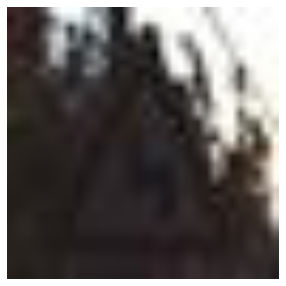

In [26]:
prediction('../input/traffic-signs-classification/myData/21/00000_00022.jpg')


Recognized Traffic Sign : Speed limit (50km/h) 



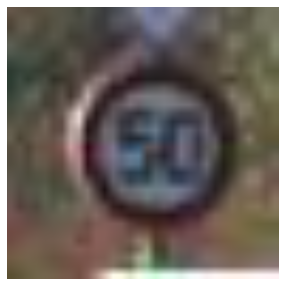

In [27]:
prediction('../input/traffic-signs-classification/myData/2/00000_00014.jpg')


Recognized Traffic Sign : End of all speed and passing limits 



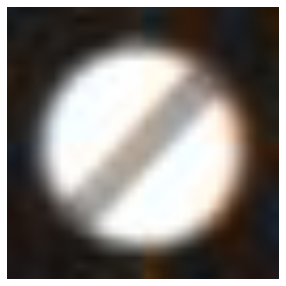

In [28]:
prediction('../input/traffic-signs-classification/myData/32/00002_00024.jpg')


Recognized Traffic Sign : End of no passing by vechiles over 3.5 metric tons 



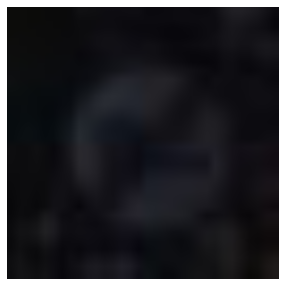

In [29]:
prediction('../input/traffic-signs-classification/myData/42/00000_00016.jpg')

**Saving The Model**

In [31]:
torch.save(model,'traffic_sign_recognition.pt')